### The plan:

0. Basic algebraic operations in R.
1. Eigenvalues and eigenvectors in R.
2. PCA (principal component analysis).
3. SVD (singular value decomposition).  


In [2]:
options(width = 120)
library(data.table)
library(scatterplot3d)
library(Rtsne)
library(proxy)


### Basic algebraic operations in R

A little recollection from our first lab and the linear algebra lecture:


In [13]:
myVector1 = 1:3
myVector2 = seq(6,2,-2)

# # Euclidean norm (Lp2):
# sqrt(sum(myVector1^2))  # this is the vector's length

# # a dot product of two vectors:
# myVector1 %*% myVector2

# is(myVector1 %*% myVector2)
# is(sum(myVector1 * myVector2)) # the class is different 

# matrices
myMatrix = matrix(c(1,2,3,3,2,1,1,2,1), nrow = 3, byrow = TRUE)


# # adding a column
tmpMatrix = cbind(myMatrix, myVector1)
colnames(tmpMatrix) = NULL
# tmpMatrix

# # transposed matrix:
# t(tmpMatrix)
# all(tmpMatrix == t(t(tmpMatrix)))

# # matrix multiplication:
# tmpMatrix %*% t(tmpMatrix) # a symmetric matrix of size 3x3 (dot products of rows)

# t(tmpMatrix) %*% tmpMatrix # a symmetric matrix of size 4x4 (dot products of columns)

# # matrix multiplication is not commutative!

symmetricMatrix = t(tmpMatrix) %*% tmpMatrix

# # Frobenius norm of a matrix:
# norm(as.matrix(c(2)), type = "F") # it's an equivalent of the Euclidean norm for vectors
symmetricMatrix

11,10,7,10
10,12,10,12
7,10,11,8
10,12,8,14


### Eigenvalues and eigenvectors

_Eigenvector_ of a $n \times n$ matrix M is a vector $e$ such that $M * e = v*e$, where $v$ is a scalar called _eigenvalue_. The notion of eigenvector has numerous practical applications in the context of data mining and data exploration. This script covers only a few.    

With R we may compute eigenvalues and eigenvectors using several available implementations. For smaller matrices it can be done using the function _eigen_.


In [37]:
# computation of eigenvectors and eigenvalues
eigenVectors = eigen(symmetricMatrix, symmetric = FALSE, only.values = FALSE)

eigenVectors # the eigenvectors are in columns of the matrix
eigenVectors$vectors[1,]

(symmetricMatrix %*% eigenVectors$vectors[,1]) / eigenVectors$values[[1]]

eigen() decomposition
$values
[1]  4.083628e+01  4.752037e+00  2.411681e+00 -1.595218e-15

$vectors
           [,1]        [,2]        [,3]       [,4]
[1,] -0.4669091 -0.35446054  0.78877472  0.1849001
[2,] -0.5408352  0.08925469 -0.08498938 -0.8320503
[3,] -0.4372552  0.81947458  0.02274017  0.3698001
[4,] -0.5461694 -0.44142126 -0.60835363  0.3698001


[1] -0.4669091 -0.3544605  0.7887747  0.1849001

-0.4669091
-0.5408352
-0.4372552
-0.5461694


### Principal component analysis (PCA).

The first application of the notion of eigenvalues is related with data visualization, visual data exploration, and dimensionality reduction.    

Often, we would like to find directions along which our data aligns or in other words, directions of the highest variance in the data. If we consider rows in a matrix $M$ as points from $R^k$, then the direction of the highest variance in the data corresponds to the first eigenvector of the column covariance matrix of $M$ (i.e., to the eigenvector with the highest eigenvalue). 


In [41]:
# Let's load some data:
dataSet = read.table(file = file.path(getwd(), "wdbc.data"), header = F, sep=',', row.names=1, na.strings="?")
colnames(dataSet) = c("diagnosis",
                      paste(c(rep("mean",10), rep("SE",10), rep("worst",10)),
                            rep(c("radius", "texture", "perimeter", "area",
                                  "smoothness", "compactness", "concavity",
                                  "concave_points", "symmetry", "fractal_dimension"),3),
                            sep="_"))

# for convenience, we create a copy of decision values and we remove them from the data.frame
classificationVector = dataSet$diagnosis
dataSet$diagnosis = NULL


head(dataSet)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,⋯,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,⋯,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,⋯,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,⋯,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,⋯,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,⋯,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
843786,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,⋯,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


This data set, called Breast Cancer Wisconsin (Diagnostic) Data Set, consists of vectors of some basic
characteristics computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe the cell nuclei present in the image. The decision value in the data says whether the detected tumor is: _B = benign_ or _M = malignant_.    

The directions that we are looking for, correspond to eigenvectors of the matrix $t(dataSet) \%*\% dataSet$ (after centering and scaling the data) with the highest eigenvalues. You may want to compute the eigenvectors 'manually' as an exercise. In the code below, however, we will use the function _prcomp_.


[1] "sdev"     "rotation" "center"   "scale"    "x"

[1] 3.644394 2.385656 1.678675 1.407352 1.284029 1.098798

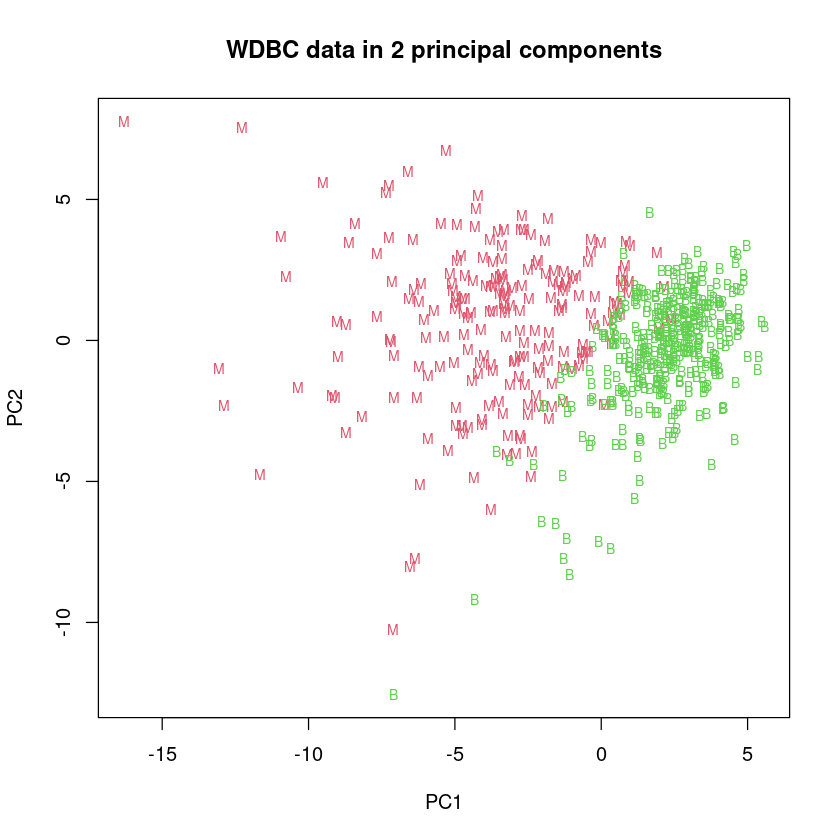

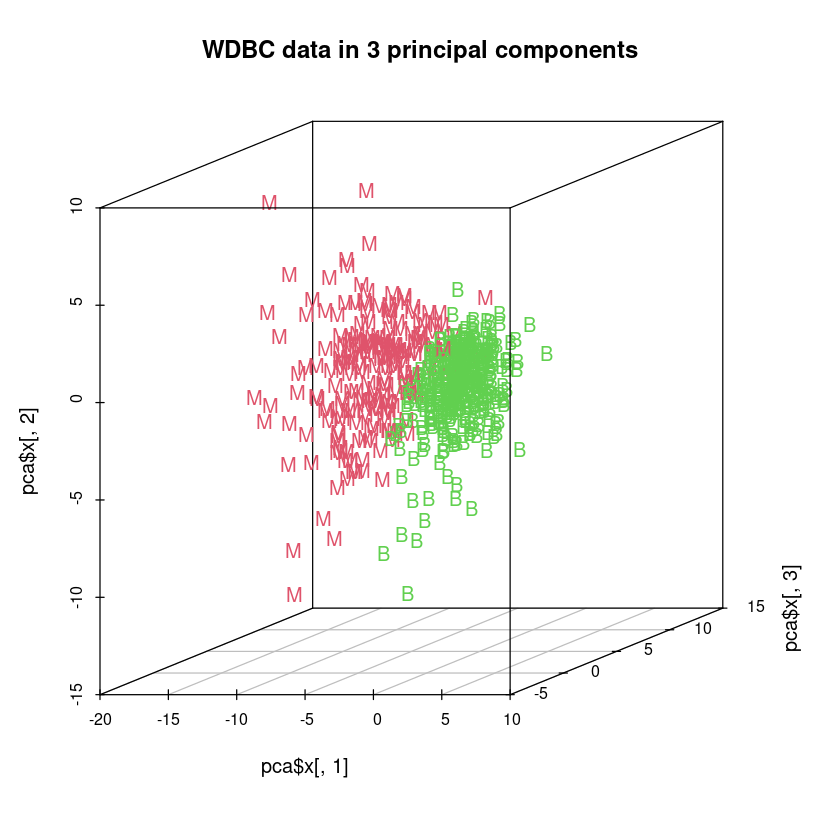

In [59]:
# computation of principal components
pca = prcomp(dataSet, center=TRUE, scale=TRUE)

names(pca)

# eigenvalues (standard deviations in the directions of eigenvectors):
head(pca$sdev)

# a matrix of eigenvectors:
# head(pca$rotation)[, 1:7]

# the data transformed into the new space:
# head(pca$x)[, 1:7]

# now, we may plot the principal components:
# screeplot(pca, npcs = 30, type = "barplot")

# head(pca$x[,c(1,2)])
# head(dataSet)
# classificationVector
# and we can visualize the data in the subspace of the first two components:
plot(pca$x[,c(1,2)], col = 4 - as.integer(factor(classificationVector)), 
     pch=as.character(classificationVector), cex=0.7, main="WDBC data in 2 principal components")

# we may also create a 3d plot (but you could also use some more sophisticated libraries for that...)
scatterplot3d(x = pca$x[,1], y = pca$x[,3], z = pca$x[,2],
              pch = as.character(classificationVector), color = 4 - as.integer(factor(classificationVector)), 
              angle = 20, main="WDBC data in 3 principal components")


A common application of PCA is in the dimensionality reduction. A different technique that is often used to visualize high dimensional data is called _t-SNE_. It also uses PCA as a data preprocessing step.



44.7073759,11.427948
46.0051743,5.618731
-37.6342412,-9.953985
-20.7000166,21.488166
-36.0558598,-14.939242
20.7224833,-30.021229
-48.3624423,-12.581903
0.7725607,-42.036642
21.7345576,-33.284291
20.6996408,-28.566537
-25.6921187,-52.355307


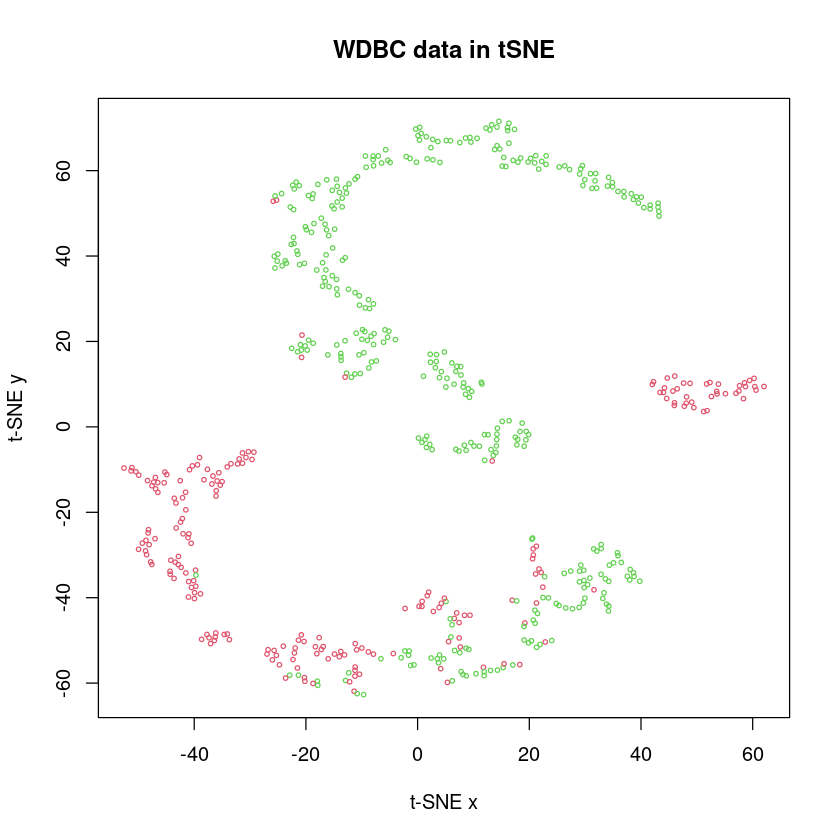

In [62]:
tSNE = Rtsne::Rtsne(dataSet, dims = 2, initial_dims = 15, perplexity = 10,
                    max_iter = 1000, theta = 0.1, verbose = FALSE)
head(tSNE)
plot(tSNE$Y, type = 'p', xlab= 't-SNE x', ylab = 't-SNE y', 
     main = 'WDBC data in tSNE', col = 4 - as.integer(factor(classificationVector)), cex = 0.5)


### Singular value decomposition (SVD)

Any matrix $X$ with dimensions $m \times n$ and rank $r$ we can decompose into a product: $X = U * D * t(V)$,
where:

 - $U$ is a matrix $m \times r$, its columns are ortonormal and they correspond to eigenvectors of $X X^T$,
 - $V$ is a matrix with dimensions $n \times r$, ortonormal columns and they correspond to eigenvectors of $X^T X$,
 - and $D$ is a diagonal matrix of size $r \times r$, and its values correspond to eigenvalues of $X X^T$ and $X^T X$ (the eigenvalues of those two matrices are the same).
 
We can easily compute the SVD decomposition of a matrix using the _svd_ function, however, please note that there are also some much more computationally efficient alternatives.


In [72]:
tmpMatrix %*%t(tmpMatrix)

eigen(tmpMatrix %*%t(tmpMatrix))

# eigen(t(tmpMatrix) %*%(tmpMatrix))

15,12,11
12,18,14
11,14,15


eigen() decomposition
$values
[1] 40.836282  4.752037  2.411681

$vectors
           [,1]       [,2]        [,3]
[1,] -0.5330736  0.8445512 -0.05065352
[2,] -0.6278226 -0.4349892 -0.64546356
[3,] -0.5671608 -0.3122781  0.76210958


In [90]:
mySVD = svd(tmpMatrix)
names(mySVD)

D = diag(mySVD$d)
U = mySVD$u
V = mySVD$v

U
D
V

# tmpMatrix

# U %*% D %*% t(V)

# # we expect some numerical issues
# all(tmpMatrix == (U %*% D %*% t(V)))  

# # it's correct with a precision greater than 10^{-10}
# all(abs(tmpMatrix - (U %*% D %*% t(V))) < 10^(-10))  


ERROR: Error in as.matrix(x): object 'tmpMatrix' not found


How can SVD be used in the context of data mining? Let's try to use it to construct a simple recommender system.    

Imagine that you are starting a Netflix-like business - you stream movies to your users. You start small - at the beginning you have only seven users and you've collected ratings of movies that they watched...


In [89]:
# link to the data:
# https://drive.google.com/file/d/1GYmOYzjKQskigEx0748jeY0BKzxkw9Dy/view?usp=sharing

# 5 - person loved the movie, 1 - person hated the movie, 0 - did not see the movie
movieRatings = read.table(file = "movieRatings.csv", header = T, row.names= 1, sep = ",")
movieRatings = as.matrix(movieRatings)
movieRatings

# Now, let's compute SVD and interpret it...
ratingsDataSVD = svd(movieRatings)


,Star.Trek,Titanic,Notting.Hill,Alien,Blade.Runner
Asia,0,4,4,0,0
Piotrek,2,0,0,3,4
Bartek,3,0,0,4,5
Gosia,0,5,5,0,0
Tomek,2,0,0,3,4
Romek,1,0,0,2,3
Kasia,0,3,3,0,0


The columns of matrices $U$, $V$ and $D$ of the decomposition can be interpreted as information about some _hidden concepts_ in our data.   

 - We will interpret the values from the diagonal matrix $D$ as the relevance of those hidden concepts.
 - The columns of matrix $V$ will tell us about the relation between the concepts and movies (the columns) from our data.
 - The columns of matrix $U$ will tell us about the relation between the concepts and persons (the rows) from our data.


In [88]:
names(ratingsDataSVD$d) = paste("concept", 1:5, sep = "")
# only the first two 'concepts' are significant
round(ratingsDataSVD$d, 3)

rownames(ratingsDataSVD$v) = colnames(movieRatings)
colnames(ratingsDataSVD$v) = paste("concept", 1:5, sep = "")
# movies with a high absolute value in a column have a strong association with the corresponding concept 
round(ratingsDataSVD$v, 3)

rownames(ratingsDataSVD$u) = rownames(movieRatings)
colnames(ratingsDataSVD$u) = paste("concept", 1:5, sep = "")
# analogically, persons with a high absolute value in a column have a stron association with the corresponding concept
round(ratingsDataSVD$u, 3)


ERROR: Error in names(ratingsDataSVD$d) = paste("concept", 1:5, sep = ""): object 'ratingsDataSVD' not found


From a short glipse on the matrices $V$ and $U$, we can tell that there are two significant concepts hidden in our data that correspond to some specific movie types (would you be able to give them a name?). Similarly, some persons are more associated with one concept, than the other.    

Let's focus on the most significant concepts.


In [87]:
D = diag(ratingsDataSVD$d[1:2])
V = ratingsDataSVD$v[,1:2]
U = ratingsDataSVD$u[,1:2]
D
V
U
approxData = U %*% D %*% t(V)

round(approxData)

# we can use SVD to reduce the size of data without losing any information!
# That could be huge saving of data storage...
all(round(approxData) == movieRatings)


ERROR: Error in diag(ratingsDataSVD$d[1:2]): object 'ratingsDataSVD' not found


Now, let use SVD to recommend a movie to our new customer.



In [86]:
# first, we ask our customer to fill a survey and give us some movie ratings
Basia = c(0, 1, 0, 0, 5)
names(Basia) = colnames(movieRatings)
Basia
V
# how our Basia fits to the discovered concepts?
conceptRepresentation = Basia %*% V
# round(conceptRepresentation, 3)

# # which movies can we recommend to Basia?
preferencePrediction = conceptRepresentation %*% t(V)
colnames(preferencePrediction) = colnames(movieRatings)
# round(preferencePrediction, 3)

# # we may want to scale our prediction, so that they fit to known ratings:
a = round(mean((Basia/preferencePrediction)[Basia > 0]) * preferencePrediction)
# print(a)
# print(preferencePrediction)
cat("We will recommend that Basia see ", 
    names(sort(preferencePrediction[, Basia == 0], decreasing = TRUE)[1]), 
    " as her next movie.\n")

# # how similar is Basia to others? can we assign her to any customer profile?
# # first, we need to map others into our concept space:
conceptData = movieRatings %*% V
round(conceptData, 3)

# # then, we compute cosine similarity
sort(proxy::simil(conceptData, conceptRepresentation, "cosine")[, 1], decreasing = TRUE)
rm(list = ls())


Star.Trek      Titanic Notting.Hill        Alien Blade.Runner 
           0            1            0            0            5

,concept1,concept2
Star.Trek,-3.818222e-01,9.522692e-17
Titanic,1.110223e-16,7.071068e-01
Notting.Hill,1.045171e-16,7.071068e-01
Alien,-5.589441e-01,-5.551115e-17
Blade.Runner,-7.360661e-01,1.110223e-16


We will recommend that Basia see  Alien  as her next movie.


,concept1,concept2
Asia,0.000,5.657
Piotrek,-5.385,0.000
Bartek,-7.062,0.000
Gosia,0.000,7.071
Tomek,-5.385,0.000
Romek,-3.708,0.000
Kasia,0.000,4.243


Piotrek     Tomek     Romek    Bartek     Gosia     Kasia      Asia 
0.9820386 0.9820386 0.9820386 0.9820386 0.1886804 0.1886804 0.1886804

For larger data it may be necessary to use some more computationally efficient implementation of SVD, e.g., from the library _irlba_. It is important to use for this purpose a sparse representation of data.

### The first data mining assignment
Below you will find a link to a data set that is going to be used in our first data mining project:
https://drive.google.com/drive/folders/1vGVAcb0reBKYFfnW6OVXMf4LKtqRLYJi?usp=sharing

To download the data you need to be logged in using your Gmail account from the uw.edu.pl domain.

Records in this data set describe decks of cards used in a popular collectible card video game _Clash Royale_. These decks were obtained using RoyaleAPI.com service, from games which took place in January 2019. Each record consists of five values:

  - a timestamp of the game (column timestamp),
  - arena ID (column arena_id – higher the arena, more skilled/experienced a player is)
  - outcome of a game (column has_won, 1 – the player won, 0 the player lost)
  - a player ID (column tag)
  - list of exactly eight cards in the player’s deck separated by “_” signs (column player_deck)  

Your task is to analyze this data and search for interesting card usage patterns, and interactions/dependencies between cards. For example:

  - please find card combos that were particularly popular in January 2019 (e.g., top 100 card sets with regard to their support, top 100 card sets of size 2, size 3, etc.),
  - identify those card combos which have high win-rates (e.g., top 100 card sets with regard to win-rate and with support > 1%),
  - does the card usage/popularity/effectiveness changes in time?
  - does the arena level have any influence on card usage/popularity/effectiveness?
  - find interesting associations between cards,
  - can you cluster players according to their play patterns and card preferences? 
  
Additionally, design and construct a card recommender system that allows players to indicate _four_ cards which they want to have in a deck, and recommends the remaining four to create a reasonable deck. How can you evaluate the effectiveness of your recommendations?
  
Report your discoveries in the form of R notebook (with code and all computation outcomes). Please remember about visualizations – make this report as interesting for a reader as you can.

The deadline for sending the reports is Sunday, April 18.

Good luck!    


\
\
\
  
  
  
